Group Members: Dhruv, Rohan, Sarthak, Uday

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

TODO: hyperparameters in UPPERCASE

# Data Preprocessing

## Reading data

In [3]:
TICKERS = ['EURUSD=X', 'EURGBP=X', 'GBP=X']
START_DATE = "2005-01-01"
TEST_TICKER = TICKERS[-1] # if we need to debug for a single ticker
THETA = 0.01

TODO: THETA has to depend on instrument considered, curencies are relatively more stable than equities

In [4]:
df_ts = yf.download(TICKERS, start=START_DATE)['Close'].dropna() # time series data

[*********************100%***********************]  3 of 3 completed


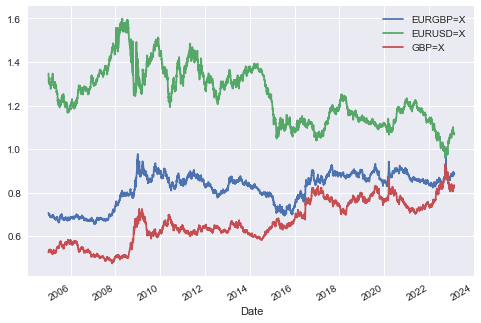

In [5]:
df_ts.plot()

In [6]:
df_ts.pct_change().describe()

,EURGBP=X,EURUSD=X,GBP=X
count,4698.000000,4698.000000,4698.000000
mean,0.000065,-0.000023,0.000116
std,0.005705,0.007324,0.006099
min,-0.104617,-0.133526,-0.034248
25%,-0.002800,-0.003273,-0.003153
50%,0.000000,0.000000,0.000056
75%,0.002839,0.003202,0.003249
max,0.116407,0.173079,0.082296


## Generating Directional Change (DC) data

TODO: peaks and troughs are recognized in hindsight

In [13]:
def get_DC_data(data: pd.Series, theta: float) -> tuple:
    """Returns the Directional Change (DC) data for a given price series.

    Args:
        data (pd.Series): price
        theta (float): threshold

    Returns:
        tuple: tuple of pd.Series for Directional Change Confirmation and Extreme Points (DCC,EXT)
    """

    rets = data.pct_change().dropna().to_numpy() # pct change returns
    DCC = [] # idx for directional change confirmations
    EXT = [] # idx for extreme points

    prev_sign = np.sign(rets[0]).astype(int) # store sign(return) from the previous time step
    accumulated = rets[0] # accumulated % return
    idx_change = 0 # index the direction changes, candidate for EXT
    sign_already_flagged = 0

    for idx,ret in zip(range(1,len(rets)),rets[1:]):
        
        ret_sign = np.sign(ret).astype(int)

        if (ret_sign!=prev_sign):
            # sign is different from previous time step, trend ends
            idx_change = idx-1 # previous price point is a candidate for EXT
            accumulated = ret # reset accumulated sum
            
            
        # same sign
        elif ret_sign != sign_already_flagged:
            # once we flag a threshold, we don't flag it again for the same trend
            # a peak has to be followed by a trough and vice versa
            accumulated += ret
            if np.abs(accumulated) > THETA:
                # we cross the threshold
                DCC.append(idx)
                EXT.append(idx_change)
                sign_already_flagged = ret_sign
        
        prev_sign = ret_sign # set the last seen sign to the current sign

    DCC = data.iloc[1:].iloc[DCC]
    EXT = data.iloc[1:].iloc[EXT]

    return (DCC,EXT)

In [19]:
dcc = {}
ext = {}
for ticker in TICKERS:
    dcc[ticker], ext[ticker] = get_DC_data(df_ts[ticker], THETA)

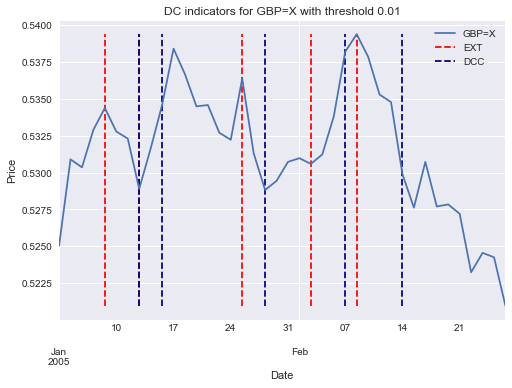

In [48]:
# example
sample_ts = df_ts[TEST_TICKER][:40]
last_date = sample_ts.index[-1]
sample_dcc = dcc[TEST_TICKER].loc[:last_date].index
sample_ext = ext[TEST_TICKER].loc[:last_date].index

fig,ax = plt.subplots()
sample_ts.plot(ax=ax)
ymin, ymax = sample_ts.min(), sample_ts.max()
ax.vlines(sample_ext, ymin, ymax, 'r','dashed',label='EXT')
ax.vlines(sample_dcc, ymin, ymax, 'navy','dashed',label='DCC')
ax.set_title(f"DC indicators for {TEST_TICKER} with threshold {THETA}")
ax.set_ylabel("Price")
ax.legend()
plt.show()